# 04. Lasso Regression
__Capstone project: Duration of the insertion of real estate advertisements for rental apartments in Switzerland__

I choose this model because Lasso regression works well in case of high dimensionality and multicollinearity among the variables in the data set. For my data, this is the case. Furthermore, the L1 regularization will be helpful for features selection.

For the Lasso regression model, the number of features included will be determined by the L1 regularization. The lasso regularization L1 penalizes the absolute value of the coefficients. The Lasso regression shrinks the less important feature’s coefficient to zero. Thus the L1 regularization  removes features with zero coefficients and therefore reduces the number of features alltogether. 

As part of pre-processing I will standardize the data using StandardScaler. I will tune the L1 pentaly "alpha" in order to regularize the model and to prevent overfitting. I will use GridSearchCV to find the hyperparameter with the help of a validation set. I will use Cross Validation with K-Folds. I believe 5 iterations should be sufficient.

In [1]:
# import commands
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("Data/df_after_eda.csv", delimiter=",")

In [3]:
df.shape

(921886, 142)

## Split data

First I will load the features into a feature matrix X and the target value into an output vector y. 

In [4]:
X = df.drop("Insertionsdauer", axis=1).values
y = df["Insertionsdauer"].values

I decided to split my data 80% - 20%, because I have a lot of data points and the proportion of testing data should be enough. Furthermore I chose the number 8 for the the random_state, as it is my lucky number.

In [5]:
from sklearn.model_selection import train_test_split

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=8)

In [6]:
print("Shape X_tr:", X_tr.shape)
print("Shape y_tr:", y_tr.shape)

Shape X_tr: (737508, 141)
Shape y_tr: (737508,)


In [7]:
print("For my training data, the dimensionality is {:}".format(X_tr.shape[1]),"and the cardinality is {:}.".format(X_tr.shape[0]),)

For my training data, the dimensionality is 141 and the cardinality is 737508.


## Downsampling training data 

Since my dataframe is very big, the calculation for the hyperparametertuning incl. CV and GridSearch takes a lot of time. Therefore I decided to downsample my training and validation data to something more manageable, yet representative, in order to identify suitable hyperparameters or a least the best range for the hyperparameters. I will use sklearn's resample method and keep 30'000 samples. I am not concernd about inbalanced categorical data, as my target is a numerical. Otherwise, I could use the arugment ``stratify`` to preserve the distribution in the original classes of a selected categorical feature. 

In [8]:
from sklearn.utils import resample
X_tr_sample = resample(X_tr, random_state=8, n_samples=30000, replace=False)
X_tr_sample.shape

(30000, 141)

In [9]:
y_tr_sample = resample(y_tr, random_state=8, n_samples=30000, replace=False)
y_tr_sample.shape

(30000,)

## Lasso regression

### Hyperparameter tuning with sample data

In [10]:
# import commands
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

In [11]:
# Create pipeline
lasso_pipe = Pipeline([("scaler", StandardScaler()),
                       ("lasso", Lasso(random_state=0, tol=0.1))])
# In case of convergence warning: 
# raise the tolerance (convergence criteria met more easily) or use more iterations max_iter (model tries to meet convergence for longer).

In [12]:
# define range for alpha
lasso_grid = {"lasso__alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10]}

In [13]:
# Search of parameters, using 5 fold cross validation
lasso_grid_cv = GridSearchCV(lasso_pipe, lasso_grid, scoring='neg_mean_absolute_error', return_train_score=True, verbose=1,  n_jobs=-1, cv=5)

In [14]:
import warnings
from sklearn.exceptions import ConvergenceWarning

# Filter convergence warnings
warnings.simplefilter("ignore", ConvergenceWarning)

# Fit estimator
lasso_grid_cv.fit(X_tr_sample, y_tr_sample)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('lasso',
                                        Lasso(random_state=0, tol=0.1))]),
             n_jobs=-1,
             param_grid={'lasso__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

#### Evaluation

In [15]:
print("With my downsampled data, the best alpha is {:}".format(lasso_grid_cv.best_params_),
      "and the best MAE score is {:.3f}.".format((lasso_grid_cv.score(X_tr_sample, y_tr_sample))*-1))

With my downsampled data, the best alpha is {'lasso__alpha': 0.001} and the best MAE score is 0.851.


A low alpha values means that not much regularization is needed, my model wants to keep penalty cost at minimum.

In [16]:
# Visualize the results in a DataFrame
lasso_cv_results = pd.DataFrame(lasso_grid_cv.cv_results_)

# Print a few interesting columns
cols = [
    "mean_test_score",
    "std_test_score",
    "mean_train_score",
    "std_train_score",
    "rank_test_score",
    "param_lasso__alpha",
]
lasso_cv_results[cols].sort_values("mean_test_score", ascending=False)

,mean_test_score,std_test_score,mean_train_score,std_train_score,rank_test_score,param_lasso__alpha
1,-0.854727,0.009174,-0.850813,0.002207,1,0.001
0,-0.854743,0.009264,-0.850573,0.002216,2,0.0001
2,-0.857632,0.008500,-0.855319,0.002237,3,0.01
3,-0.889838,0.010070,-0.889583,0.002292,4,0.1
4,-0.910142,0.010901,-0.910102,0.002935,5,1
5,-0.910142,0.010901,-0.910102,0.002935,5,10


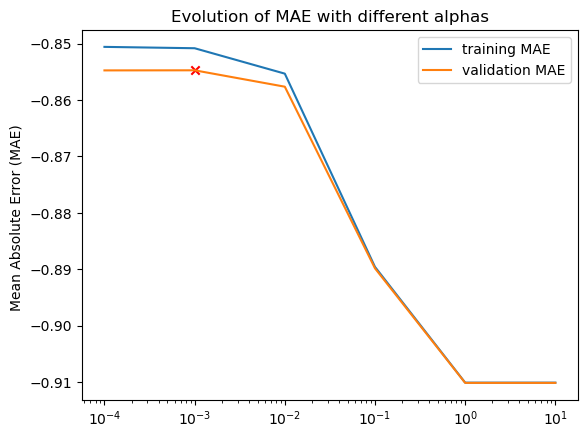

In [17]:
# get point for marker for best score
best_mae= lasso_grid_cv.best_score_
best_alpha = list(lasso_grid_cv.best_params_.values())

# Plot training/validation accuracy curves
plt.semilogx(
    lasso_cv_results["param_lasso__alpha"],
    lasso_cv_results["mean_train_score"],
    label="training MAE",
)
plt.semilogx(
    lasso_cv_results["param_lasso__alpha"],
    lasso_cv_results["mean_test_score"],
    label="validation MAE",
)

# Add marker for best score
plt.scatter(x=best_alpha, y=best_mae, marker="x", c="red")

plt.ylabel("Mean Absolute Error (MAE) ")
plt.title("Evolution of MAE with different alphas")
plt.legend()
plt.show()

The curves from the training an validation MAE show, that a low alpha clearly gives the best performance. The training and validation curves are very close to each other. With a value for alpha of more than 10^-2, the MAE rating drops sharply. With a value for alpha of 0.001 or 0.0001, the performance is about the same, with only slightly better scoring for 0.001.

### Lasso regression with the whole training data

In [18]:
# Create the estimator
lasso = make_pipeline(StandardScaler(), Lasso(alpha=0.001))

# Fit it to train data
lasso.fit(X_tr, y_tr)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lasso', Lasso(alpha=0.001))])

#### Evaluation and predictions

In [19]:
# make prediction on test and train set
y_te_pred = lasso.predict(X_te)
y_tr_pred = lasso.predict(X_tr)

In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt

# calculate mae, mse, rmse and R2 for train data
print('Train set evaluation:\n_____________________________________')
print("MAE: {:.3f}".format(mean_absolute_error(y_tr, y_tr_pred)))
print('MSE: {:.3f}'.format((mean_squared_error(y_tr,y_tr_pred))))
print("RMSE: {:.3f}".format(sqrt((mean_squared_error(y_tr,y_tr_pred)))))
print('R2: {:.3f}'.format(lasso.score(X_tr, y_tr)))

# calculate mae, mse, rmse and R2 for test data
print('\nTest set evaluation:\n_____________________________________')
print("MAE: {:.3f}".format(mean_absolute_error(y_te, y_te_pred)))
print('MSE: {:.3f}'.format((mean_squared_error(y_te,y_te_pred))))
print("RMSE: {:.3f}".format(sqrt((mean_squared_error(y_te,y_te_pred)))))
print('R2: {:.3f}'.format(lasso.score(X_te, y_te)))

Train set evaluation:
_____________________________________
MAE: 0.856
MSE: 1.103
RMSE: 1.050
R2: 0.108

Test set evaluation:
_____________________________________
MAE: 0.855
MSE: 1.099
RMSE: 1.048
R2: 0.110


The results show, that I get a similar MAE score as I got why my downsampled data. In general, the MAE, MSE, RMSE and R2 score are very similar for the train and test data. This means, there is no over- or underfitting. 

#### Selected features by L1 penalty

In [21]:
# get the coefficients
coef = lasso['lasso'].coef_

In [22]:
# define labels
feat_labels = df.drop('Insertionsdauer', axis=1).columns

In [23]:
# the features that survived the Lasso regression penalty
featues_survived = np.array(feat_labels)[coef > 0]

# number of features that survived the Lasso regression penalty:
print("Number of features that survived the Lasso regression penalty:", featues_survived.shape[0])

Number of features that survived the Lasso regression penalty: 56


In [24]:
# the features that survived the Lasso regression penalty are:
featues_survived

array(['Anzahl Zimmer', 'Nettomiete pro m2 und Jahr',
       'Nettomiete pro Monat',
       'Proportion of single-family house residents',
       'Newly built apartments per 10000 inhabitants',
       'Share of 3-4 room apartments', 'Vacancy rate', 'Nutzung_Wohnung',
       'Nutzung detailliert_4.0', 'Nutzung detailliert_6.0',
       'Nutzung detailliert_8.0', 'Zustand_Erstbezug', 'Aussicht_4.0',
       'Aussicht_other', 'Balkon_1.0', 'Bauperiode_1960.0',
       'Bauperiode_1970.0', 'Bauperiode_1980.0', 'Bauperiode_2010.0',
       'Bauperiode_2015.0', 'Minergie_-1.0', 'Parkplatz aussen_unknown',
       'Parkplatz innen_unknown', 'Rollstuhlgängig_-1.0',
       'Verfügbarkeitskategorie_2.0', 'Jahr_Erste_Publikation_2015',
       'Jahr_Erste_Publikation_2017', 'Monat_Erste_Publikation_4',
       'Monat_Erste_Publikation_6', 'Monat_Erste_Publikation_7',
       'Monat_Erste_Publikation_11', 'Monat_Erste_Publikation_12',
       '9 Gmd Kat_Ländliche Zentrumsgemeinde',
       '9 Gmd Kat_Ländli

Out of the 56 features 24 are spatial categories.

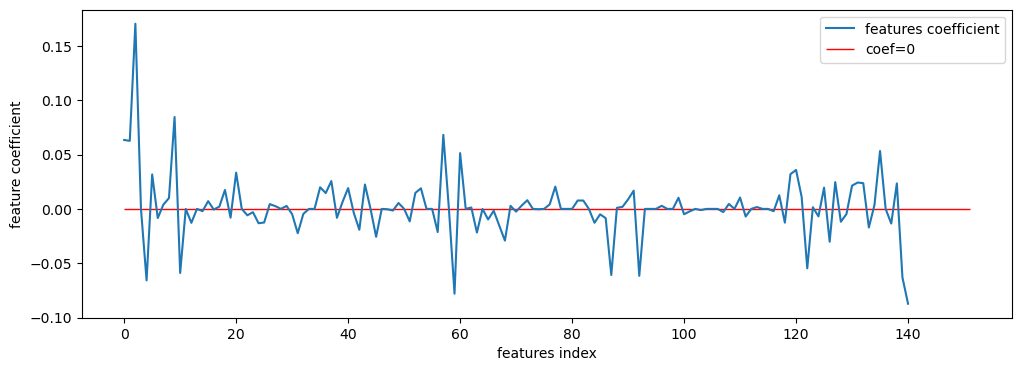

In [25]:
# plot of the features's coefficient as a line chart
#Define size of bar plot
plt.figure(figsize=(12,4))

#Plot
plt.plot(range(len(feat_labels)), coef, label="features coefficient")
plt.hlines(y=0, xmin=0, xmax=151, linewidth=1, color='r', label="coef=0")

#Add chart labels
plt.xlabel('features index')
plt.ylabel('feature coefficient')
plt.legend()

plt.show()

The scale of the coefficients is between 0,20 and -0,15 with some features clearly standing out while others are around zero.

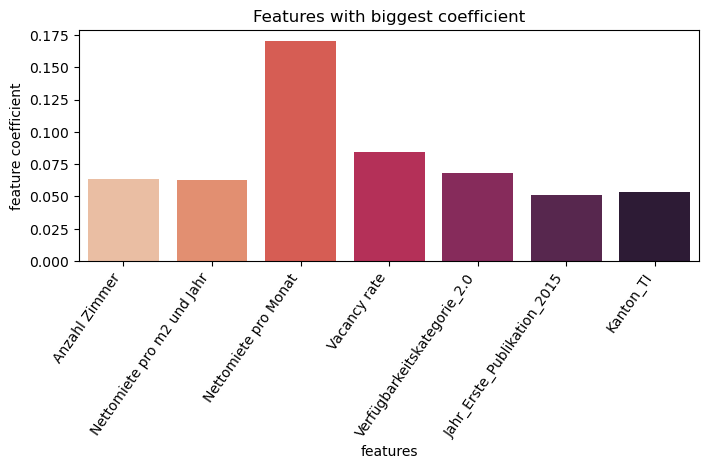

In [26]:
# plot of the most importance features with their names

#Define size of bar plot
plt.figure(figsize=(8,3))

#Plot Searborn bar chart with importance score above 0.05
sns.barplot(x=np.array(feat_labels)[coef>0.05], y=coef[coef>0.05], palette="rocket_r")

#Add chart labels
plt.title('Features with biggest coefficient')
plt.xlabel('features')
plt.xticks(rotation=55, ha="right")
plt.ylabel('feature coefficient')

plt.show()

The feature with the biggest positive coefficient is the net rent per month.

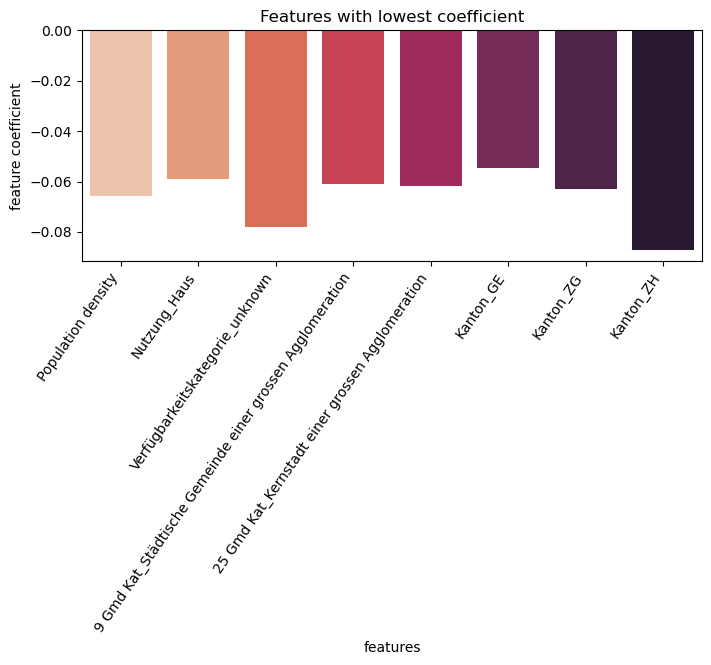

In [27]:
# plot of the most importance features with their names

#Define size of bar plot
plt.figure(figsize=(8,3))

#Plot Searborn bar chart with importance score below -0.05
sns.barplot(x=np.array(feat_labels)[coef<-0.05], y=coef[coef<-0.05], palette="rocket_r")

#Add chart labels
plt.title('Features with lowest coefficient')
plt.xlabel('features')
plt.xticks(rotation=55, ha="right")
plt.ylabel('feature coefficient')

plt.show()

The feature with the biggest negative coefficient is the canton of Zurich.

## Export

In [28]:
# Export model predictions
predictions = pd.DataFrame({'Model': 'lasso',
                            'True Value': np.exp(y_te),
                            'Prediction': np.exp(y_te_pred),
                           'Error': np.exp(y_te) - np.exp(y_te_pred)})

predictions.to_csv("ML_predictions_lasso.csv", encoding='utf-8', index=False)

In [29]:
# Export model predictions
predictions = pd.DataFrame({'Model': 'lasso',
                            'True Value': np.exp(y_tr),
                            'Prediction': np.exp(y_tr_pred),
                           'Error': np.exp(y_tr) - np.exp(y_tr_pred)})

predictions.to_csv("ML_predictions_lasso_train.csv", encoding='utf-8', index=False)

In [30]:
# Export model evaluation
evaluations=pd.DataFrame([['Lasso', mean_absolute_error(y_te, y_te_pred), mean_squared_error(y_te, y_te_pred),
                          sqrt((mean_squared_error(y_te, y_te_pred))), lasso.score(X_te, y_te)]],
                 columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2'])
evaluations.to_csv("ML_evaluations.csv", encoding='utf-8', index=False)